In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parquet_file = "E:\\Downloads\\2022_place_canvas_history_week_4.parquet"

In [ ]:
color_map = {
    "#6D001A": (109, 0, 26), "#BE0039": (190, 0, 57), "#FF4500": (255, 69, 0),
    "#FFA800": (255, 168, 0), "#FFD635": (255, 214, 53), "#FFF8B8": (255, 248, 184),
    "#00A368": (0, 163, 104), "#00CC78": (0, 204, 120), "#7EED56": (126, 237, 86),
    "#00756F": (0, 117, 111), "#009EAA": (0, 158, 170), "#00CCC0": (0, 204, 192),
    "#2450A4": (36, 80, 164), "#3690EA": (54, 144, 234), "#51E9F4": (81, 233, 244),
    "#493AC1": (73, 58, 193), "#6A5CFF": (106, 92, 255), "#94B3FF": (148, 179, 255),
    "#811E9F": (129, 30, 159), "#B44AC0": (180, 74, 192), "#E4ABFF": (228, 171, 255),
    "#DE107F": (222, 16, 127), "#FF3881": (255, 56, 129), "#FF99AA": (255, 153, 170),
    "#6D482F": (109, 72, 47), "#9C6926": (156, 105, 38), "#FFB470": (255, 180, 112),
    "#000000": (0, 0, 0), "#515252": (81, 82, 82), "#898D90": (137, 141, 144),
    "#D4D7D9": (212, 215, 217), "#FFFFFF": (255, 255, 255)
}

In [16]:

query = f"""
    WITH latest_pixels AS (
        SELECT x, y, pixel_color, timestamp
        FROM (
            SELECT x, y, pixel_color, timestamp, 
                   ROW_NUMBER() OVER (PARTITION BY x, y ORDER BY timestamp DESC) AS rn
            FROM '{parquet_file}'
        )
        WHERE rn = 1
    )
    SELECT x, y, pixel_color, timestamp
    FROM latest_pixels;
"""

df = duckdb.connect().execute(query).df()

canvas_size = (2000, 2000)

canvas = np.full(canvas_size, None, dtype=object)
timestamp_matrix = np.full(canvas_size, None, dtype=object)

for index, row in df.iterrows():
    x, y = row["x"], row["y"]
    canvas[y, x] = row["pixel_color"]
    timestamp_matrix[y, x] = row["timestamp"]

dp = np.zeros(canvas_size, dtype=int)
squares = []

for y in range(1, 2000):
    for x in range(1, 2000):
        if canvas[y, x] and canvas[y, x] == canvas[y - 1, x] == canvas[y, x - 1] == canvas[y - 1, x - 1]:
            dp[y, x] = min(dp[y - 1, x], dp[y, x - 1], dp[y - 1, x - 1]) + 1
            squares.append({
                "size": dp[y, x],
                "color": canvas[y, x],
                "timestamp": timestamp_matrix[y, x],
                "top_left": (x - dp[y, x] + 1, y - dp[y, x] + 1),
                "bottom_right": (x, y)
            })

squares_sorted = sorted(squares, key=lambda s: s["size"], reverse=True)

top_20_squares = squares_sorted[:20]

print("\nTop 20 Largest Squares Found:")
for i, square in enumerate(top_20_squares):
    print(f"\nSquare {i+1}:")
    print(f"  - Size: {square['size']}x{square['size']}")
    print(f"  - Color: {square['color']}")
    print(f"  - Timestamp: {square['timestamp']}")
    print(f"  - Coordinates: Top-Left {square['top_left']} | Bottom-Right {square['bottom_right']}")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 20 Largest Squares Found:

Square 1:
  - Size: 293x293
  - Color: #FFFFFF
  - Timestamp: 2022-04-04 22:55:27.599 UTC
  - Coordinates: Top-Left (1, 1622) | Bottom-Right (293, 1914)

Square 2:
  - Size: 293x293
  - Color: #FFFFFF
  - Timestamp: 2022-04-04 22:51:30.763 UTC
  - Coordinates: Top-Left (2, 1622) | Bottom-Right (294, 1914)

Square 3:
  - Size: 293x293
  - Color: #FFFFFF
  - Timestamp: 2022-04-04 22:54:16.591 UTC
  - Coordinates: Top-Left (3, 1622) | Bottom-Right (295, 1914)

Square 4:
  - Size: 293x293
  - Color: #FFFFFF
  - Timestamp: 2022-04-04 22:51:48.175 UTC
  - Coordinates: Top-Left (4, 1622) | Bottom-Right (296, 1914)

Square 5:
  - Size: 293x293
  - Color: #FFFFFF
  - Timestamp: 2022-04-04 22:55:11.528 UTC
  - Coordinates: Top-Left (5, 1622) | Bottom-Right (297, 1914)

Square 6:
  - Size: 293x293
  - Color: #FFFFFF
  - Timestamp: 2022-04-04 19:04:23.283 UTC
  - Coordinates: Top-Left (6, 1622) | Bottom-Right (298, 1914)

Square 7:
  - Size: 293x293
  - Color: #FFFF

In [19]:
def visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max):
    
    query = f"""
        SELECT x, y, pixel_color
        FROM '{parquet_file}'
        WHERE timestamp <= '{timestamp}'
          AND x BETWEEN {x_min} AND {x_max}
          AND y BETWEEN {y_min} AND {y_max}
        QUALIFY ROW_NUMBER() OVER (PARTITION BY x, y ORDER BY timestamp DESC) = 1;
    """

    con = duckdb.connect()
    snapshot_df = con.execute(query).df()
    con.close()

    width, height = x_max - x_min + 1, y_max - y_min + 1
    img = np.ones((height, width, 3), dtype=np.uint8) * 255  

    for _, row in snapshot_df.iterrows():
        x, y, color = row["x"], row["y"], row["pixel_color"]
        if color in color_map:
            img[y - y_min, x - x_min] = color_map[color]  

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Canvas Snapshot at {timestamp}")
    plt.axis("off")
    plt.show()



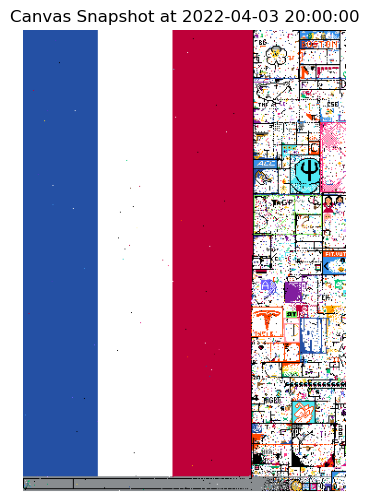

In [22]:
timestamp = "2022-04-03 20:00:00"
x_min, x_max = 1, 350
y_min, y_max = 1500, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

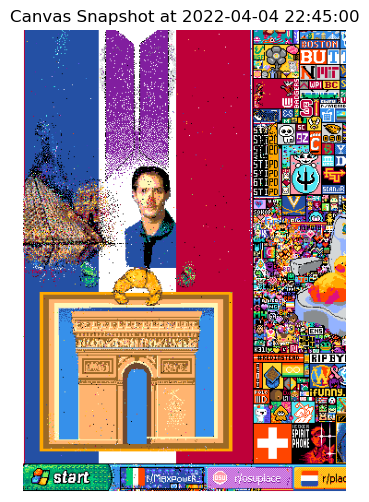

In [30]:
timestamp = "2022-04-04 22:45:00"
x_min, x_max = 1, 350
y_min, y_max = 1500, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

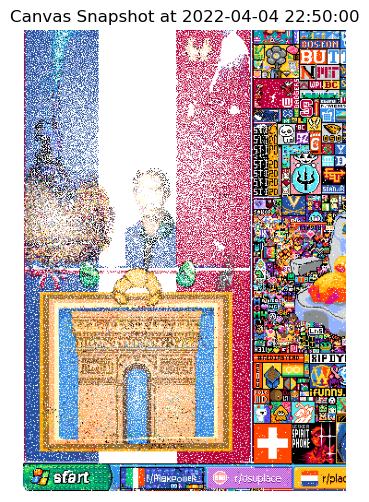

In [32]:
timestamp = "2022-04-04 22:50:00"
x_min, x_max = 1, 350
y_min, y_max = 1500, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

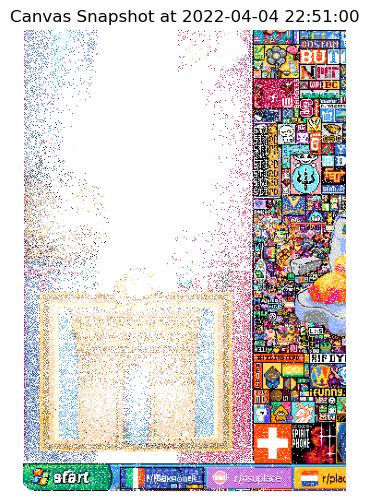

In [34]:
timestamp = "2022-04-04 22:51:00"
x_min, x_max = 1, 350
y_min, y_max = 1500, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

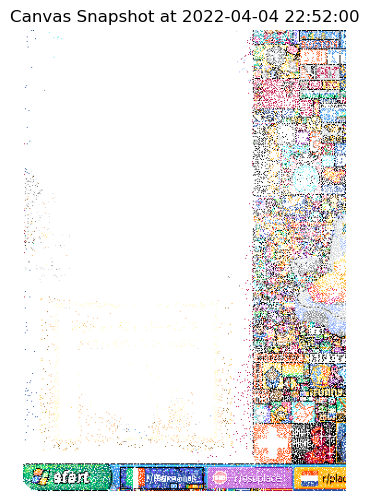

In [35]:
timestamp = "2022-04-04 22:52:00"
x_min, x_max = 1, 350
y_min, y_max = 1500, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

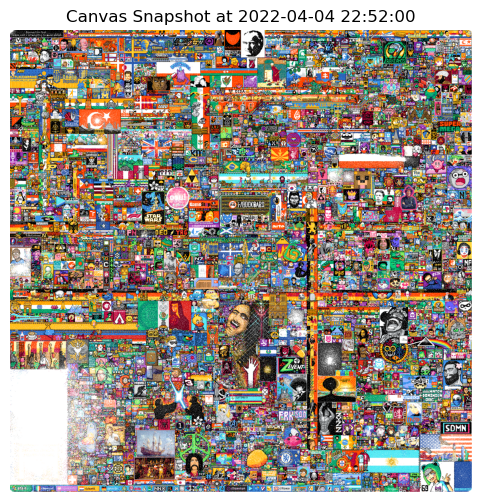

In [42]:
timestamp = "2022-04-04 22:52:00"
x_min, x_max = 1, 2000
y_min, y_max = 1, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

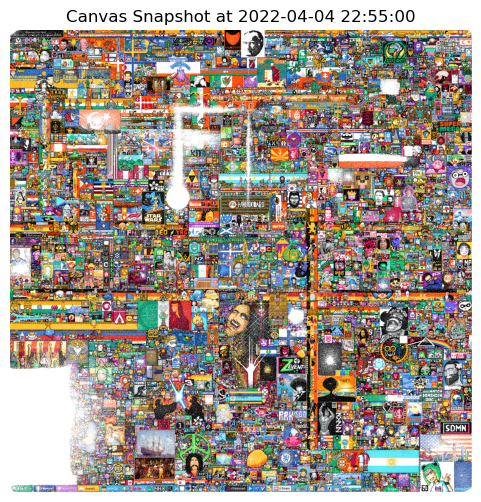

In [43]:
timestamp = "2022-04-04 22:55:00"
x_min, x_max = 1, 2000
y_min, y_max = 1, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

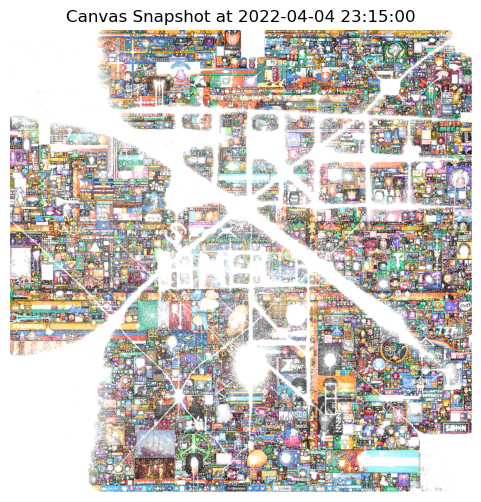

In [44]:
timestamp = "2022-04-04 23:15:00"
x_min, x_max = 1, 2000
y_min, y_max = 1, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

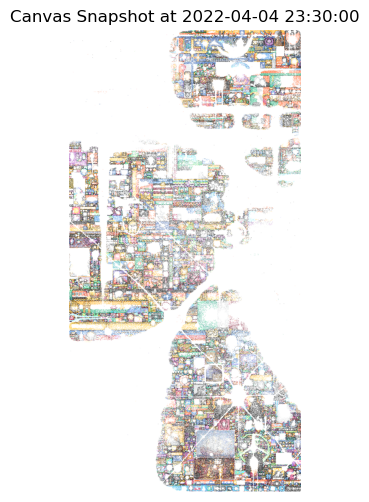

In [47]:
timestamp = "2022-04-04 23:30:00"
x_min, x_max = 1, 1000
y_min, y_max = 1, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

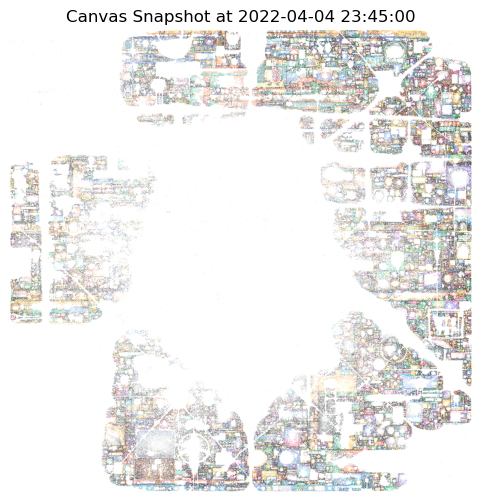

In [48]:
timestamp = "2022-04-04 23:45:00"
x_min, x_max = 1, 2000
y_min, y_max = 1, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

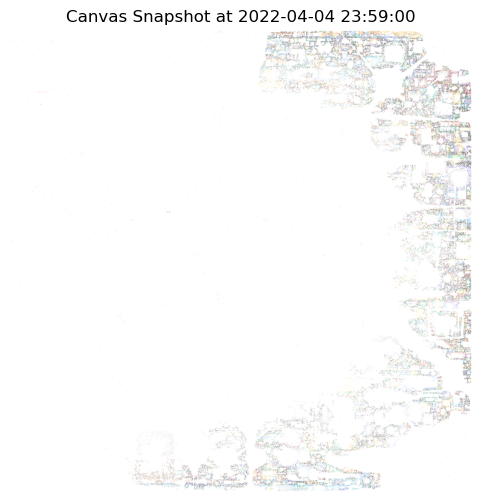

In [49]:
timestamp = "2022-04-04 23:59:00"
x_min, x_max = 1, 2000
y_min, y_max = 1, 2000

visualize_canvas_snapshot(timestamp, x_min, x_max, y_min, y_max)